<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Square sandwich plate under uniform pressure ===
R = 5.0  (P = -5.0)
Mesh = 10 x 10 Q4 elements
w_bar (normalized) = 463.2565


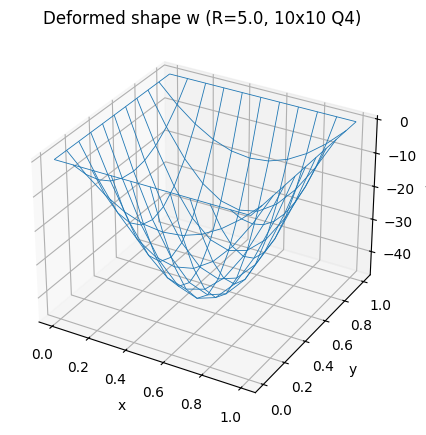


--- Normalized stresses (Table 13.1 style) ---
[ wbar,  sigma_x^1,  sigma_x^2,  sigma_x^3,  tau_xz^1,  tau_xz^2 ]
[np.float64(463.25646961571124), np.float64(18.355424483195687), np.float64(275.3313672479353), np.float64(344.16420905991913), np.float64(64.44010666942958), np.float64(4.296007111295304)]

As columns:
wbar   = 463.2565
σx^1   = 18.3554
σx^2   = 275.3314
σx^3   = 344.1642
τxz^1  = 64.4401
τxz^2  = 4.2960


(np.float64(463.25646961571124),
 (np.float64(18.355424483195687),
  np.float64(275.3313672479353),
  np.float64(344.16420905991913),
  np.float64(64.44010666942958),
  np.float64(4.296007111295304)))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Gauss + Q4
# =========================
def gaussQuadrature(option="complete"):
    if option == "complete":  # 2x2
        a = 0.577350269189626
        loc = np.array([[-a, -a],
                        [ a, -a],
                        [ a,  a],
                        [-a,  a]], dtype=float)
        w = np.array([1, 1, 1, 1], dtype=float)
    elif option == "reduced":  # 1x1
        loc = np.array([[0.0, 0.0]], dtype=float)
        w = np.array([4.0], dtype=float)
    else:
        raise ValueError("option must be 'complete' or 'reduced'")
    return w, loc


def shapeFunctionQ4(xi, eta):
    N = 0.25 * np.array([
        (1-xi)*(1-eta),
        (1+xi)*(1-eta),
        (1+xi)*(1+eta),
        (1-xi)*(1+eta)
    ], dtype=float)

    dN = 0.25 * np.array([
        [-(1-eta), -(1-xi)],
        [ (1-eta), -(1+xi)],
        [ (1+eta),  (1+xi)],
        [-(1+eta),  (1-xi)]
    ], dtype=float)  # cols: d/dxi, d/deta
    return N, dN


def Jacobian(nodeCoords_elem, naturalDerivatives):
    J = nodeCoords_elem.T @ naturalDerivatives
    invJ = np.linalg.inv(J)
    XYder = naturalDerivatives @ invJ
    return J, invJ, XYder


def rectangularMesh(Lx, Ly, nEx, nEy, centered=False):
    if centered:
        xs = np.linspace(-Lx, Lx, nEx + 1)
        ys = np.linspace(-Ly, Ly, nEy + 1)
    else:
        xs = np.linspace(0.0, Lx, nEx + 1)
        ys = np.linspace(0.0, Ly, nEy + 1)

    X, Y = np.meshgrid(xs, ys)
    nodeCoordinates = np.column_stack([X.ravel(), Y.ravel()])

    def nid(ix, iy):
        return iy*(nEx+1) + ix + 1  # 1-based

    elems = []
    for iy in range(nEy):
        for ix in range(nEx):
            n1 = nid(ix,   iy)
            n2 = nid(ix+1, iy)
            n3 = nid(ix+1, iy+1)
            n4 = nid(ix,   iy+1)
            elems.append([n1, n2, n3, n4])

    return nodeCoordinates, np.array(elems, dtype=int)


# =========================
# Srinivas material (symmetric case in your screenshots)
# =========================
def srinivasMaterial(thickness, kappa=5/6):
    """
    Symmetric Srinivas sandwich (nc=3, theta=0). B=0.
    Returns: A(3x3), B(3x3), D(3x3), S(2x2), qbarra(5x5x3)
    """
    h = thickness

    dmat = np.array([[0.999781, 0.231192, 0.0],
                     [0.231192, 0.524886, 0.0],
                     [0.0,      0.0,      0.262931]], dtype=float)

    dm = np.array([[0.26681,  0.0],
                   [0.0,      0.159914]], dtype=float)

    nc = 3
    th = np.array([0.0, 0.0, 0.0], dtype=float)

    z1 = np.array([-2*h/5,  2*h/5,  h/2], dtype=float)
    z2 = np.array([-h/2,   -2*h/5,  2*h/5], dtype=float)

    qbarra = np.zeros((5, 5, nc), dtype=float)

    A = np.zeros((3, 3), dtype=float)
    D = np.zeros((3, 3), dtype=float)
    S = np.zeros((2, 2), dtype=float)

    rf = 15.0  # skins multiplier

    for i in range(nc):
        theta = th[i]

        if i == 1:  # core
            Q = dmat.copy()
            Qs = dm.copy() * kappa
        else:       # skins
            Q = rf * dmat
            Qs = rf * dm * kappa

        q11, q12, q22, q66 = Q[0,0], Q[0,1], Q[1,1], Q[2,2]
        ss11, ss22 = Qs[0,0], Qs[1,1]

        qbarra[0,0,i] = q11
        qbarra[0,1,i] = q12
        qbarra[1,0,i] = q12
        qbarra[1,1,i] = q22
        qbarra[2,2,i] = q66
        qbarra[3,3,i] = ss11
        qbarra[4,4,i] = ss22

        dz  = (z1[i] - z2[i])
        dz3 = (z1[i]**3 - z2[i]**3) / 3.0

        # A
        A[0,0] += q11 * dz
        A[0,1] += q12 * dz
        A[1,0] += q12 * dz
        A[1,1] += q22 * dz
        A[2,2] += q66 * dz

        # D
        D[0,0] += q11 * dz3
        D[0,1] += q12 * dz3
        D[1,0] += q12 * dz3
        D[1,1] += q22 * dz3
        D[2,2] += q66 * dz3

        # S
        S[0,0] += ss11 * dz
        S[1,1] += ss22 * dz

    B = np.zeros((3, 3), dtype=float)
    return A, B, D, S, qbarra


# =========================
# BC for 5DOF Mindlin Q4
# DOF order per node (YOU ARE USING):
#   u: 1..N
#   v: N+1..2N
#   w: 2N+1..3N
#   tx:3N+1..4N
#   ty:4N+1..5N
# =========================
def EssentialBC5dof(typeBC, GDoF, xx, yy, nodeCoordinates, numberNodes):
    xmin, xmax = np.min(nodeCoordinates[:, 0]), np.max(nodeCoordinates[:, 0])
    ymin, ymax = np.min(nodeCoordinates[:, 1]), np.max(nodeCoordinates[:, 1])

    on_left   = np.where(np.isclose(xx, xmin))[0] + 1
    on_right  = np.where(np.isclose(xx, xmax))[0] + 1
    on_bottom = np.where(np.isclose(yy, ymin))[0] + 1
    on_top    = np.where(np.isclose(yy, ymax))[0] + 1
    edges_all = np.unique(np.hstack([on_left, on_right, on_bottom, on_top]))

    bc = typeBC.lower()
    if bc == "ssss":
        fixedW  = edges_all
        fixedTX = np.unique(np.hstack([on_top, on_bottom]))
        fixedTY = np.unique(np.hstack([on_left, on_right]))

        # small constraints to remove rigid body in u,v
        fixedU = np.array([1], dtype=int)
        fixedV = np.array([1], dtype=int)

    elif bc == "cccc":
        fixedW  = edges_all
        fixedTX = edges_all
        fixedTY = edges_all
        fixedU  = edges_all
        fixedV  = edges_all
    else:
        raise ValueError("typeBC supported here: 'ssss', 'cccc'")

    prescribed = np.unique(np.hstack([
        fixedU,
        fixedV + numberNodes,
        fixedW + 2*numberNodes,
        fixedTX + 3*numberNodes,
        fixedTY + 4*numberNodes
    ])).astype(int)

    allDof = np.arange(1, GDoF+1, dtype=int)
    active = np.setdiff1d(allDof, prescribed)
    return prescribed, active, fixedW


# =========================
# Stiffness for 5DOF laminated Mindlin Q4
# (DOF order [u v w tx ty])
# =========================
def formStiffnessMatrixMindlinQ45laminated5dof(GDoF, numberElements, elementNodes, numberNodes,
                                               nodeCoordinates, AMatrix, BMatrix, DMatrix, SMatrix):
    K = np.zeros((GDoF, GDoF), dtype=float)

    gw_b, gl_b = gaussQuadrature("complete")
    gw_s, gl_s = gaussQuadrature("reduced")

    for e in range(numberElements):
        indice = elementNodes[e, :]          # 1-based (4)
        nodes = indice.astype(int) - 1       # 0-based
        ndof = len(indice)                   # 4

        # [u v w tx ty]
        edof = np.hstack([
            indice,
            indice + numberNodes,
            indice + 2*numberNodes,
            indice + 3*numberNodes,
            indice + 4*numberNodes
        ]).astype(int) - 1

        # membrane + bending
        for q in range(len(gw_b)):
            xi, eta = gl_b[q, 0], gl_b[q, 1]
            wt = gw_b[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            # membrane from u,v
            Bm = np.zeros((3, 5*ndof), dtype=float)
            Bm[0, 0:ndof] = dN_xy[:, 0]              # du/dx
            Bm[1, ndof:2*ndof] = dN_xy[:, 1]         # dv/dy
            Bm[2, 0:ndof] = dN_xy[:, 1]              # du/dy
            Bm[2, ndof:2*ndof] = dN_xy[:, 0]         # dv/dx

            # bending from tx,ty
            Bb = np.zeros((3, 5*ndof), dtype=float)
            Bb[0, 3*ndof:4*ndof] = dN_xy[:, 0]       # d(tx)/dx
            Bb[1, 4*ndof:5*ndof] = dN_xy[:, 1]       # d(ty)/dy
            Bb[2, 3*ndof:4*ndof] = dN_xy[:, 1]       # d(tx)/dy
            Bb[2, 4*ndof:5*ndof] = dN_xy[:, 0]       # d(ty)/dx

            K[np.ix_(edof, edof)] += (Bb.T @ DMatrix @ Bb) * wt * detJ
            K[np.ix_(edof, edof)] += (Bm.T @ AMatrix @ Bm) * wt * detJ

            if np.linalg.norm(BMatrix) > 0:
                K[np.ix_(edof, edof)] += (Bm.T @ BMatrix @ Bb) * wt * detJ
                K[np.ix_(edof, edof)] += (Bb.T @ BMatrix @ Bm) * wt * detJ

        # shear (reduced)
        for q in range(len(gw_s)):
            xi, eta = gl_s[q, 0], gl_s[q, 1]
            wt = gw_s[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            Bs = np.zeros((2, 5*ndof), dtype=float)
            # gamma_xz = dw/dx + tx
            Bs[0, 2*ndof:3*ndof] = dN_xy[:, 0]       # dw/dx
            Bs[0, 3*ndof:4*ndof] = N                 # + tx
            # gamma_yz = dw/dy + ty
            Bs[1, 2*ndof:3*ndof] = dN_xy[:, 1]       # dw/dy
            Bs[1, 4*ndof:5*ndof] = N                 # + ty

            K[np.ix_(edof, edof)] += (Bs.T @ SMatrix @ Bs) * wt * detJ

    return K


# =========================
# Force vector for uniform transverse load P on w (reduced)
# =========================
def formForceVectorMindlinQ45dof(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, P):
    F = np.zeros((GDoF, 1), dtype=float)
    gw, gl = gaussQuadrature("reduced")

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        ndof = len(indice)

        wdof = (nodes + 2*numberNodes).astype(int)

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]
            wt = gw[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            F[wdof, 0] += (N * P) * wt * detJ

    return F


# =========================
# Solve K U = F with essential BC
# =========================
def solution(GDoF, prescribedDof, K, F):
    allDof = np.arange(1, GDoF+1, dtype=int)
    activeDof = np.setdiff1d(allDof, prescribedDof)

    a0 = activeDof - 1
    p0 = prescribedDof - 1

    Kaa = K[np.ix_(a0, a0)]
    Fa = F[a0, :]

    Ua = np.linalg.solve(Kaa, Fa)

    U = np.zeros((GDoF, 1), dtype=float)
    U[a0, :] = Ua
    U[p0, :] = 0.0
    return U


def plot_w_surface(xx, yy, w, nEx, nEy, title="w(x,y)"):
    Nx = nEx + 1
    Ny = nEy + 1
    X = xx.reshape(Ny, Nx)
    Y = yy.reshape(Ny, Nx)
    W = w.reshape(Ny, Nx)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(X, Y, W, rstride=1, cstride=1, linewidth=0.6)
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("w")
    plt.show()


# =========================
# SrinivasStress - FIXED for your DOF order [u v w tx ty]
# Keep MATLAB formulas, only remap dof blocks
# =========================
def SrinivasStress_uvwtt(numberElements, elementNodes, numberNodes, nodeCoordinates, qbarra, U, h):
    """
    Based on your screenshots of SrinivasStress.m.
    Your global DOF order: [u, v, w, tx, ty]
    Outputs:
      stress_layer1/2/3: (ne,4,3) -> [sx, sy, txy] at 2x2 Gauss points
      shear_layer1/2:    (ne,1,2) -> [txz, tyz] at reduced Gauss point
    """
    stress_layer1 = np.zeros((numberElements, 4, 3), dtype=float)
    stress_layer2 = np.zeros((numberElements, 4, 3), dtype=float)
    stress_layer3 = np.zeros((numberElements, 4, 3), dtype=float)

    shear_layer1 = np.zeros((numberElements, 1, 2), dtype=float)
    shear_layer2 = np.zeros((numberElements, 1, 2), dtype=float)

    # ---- bending/membrane stresses (complete) ----
    gw, gl = gaussQuadrature('complete')

    for e in range(numberElements):
        indice = elementNodes[e, :].astype(int)     # 1-based nodes (4)
        nodes0 = indice - 1
        nn = len(indice)

        # element dof vector Ue in order [u v w tx ty] blocks
        dof_u  = indice
        dof_v  = indice + numberNodes
        dof_w  = indice + 2*numberNodes
        dof_tx = indice + 3*numberNodes
        dof_ty = indice + 4*numberNodes

        indiceB = np.hstack([dof_u, dof_v, dof_w, dof_tx, dof_ty]).astype(int) - 1
        Ue = U[indiceB, 0]  # size 5*nn

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, XY = Jacobian(nodeCoordinates[nodes0, :], dN_nat)

            # MATLAB B_b uses tx,ty blocks 2 and 3 (because their order was w,tx,ty,u,v)
            # Here our tx,ty are blocks 4 and 5 -> indices 3*nn..4*nn and 4*nn..5*nn
            B_b = np.zeros((3, 5*nn), dtype=float)
            B_b[0, 3*nn:4*nn] = XY[:, 0]   # d(tx)/dx
            B_b[1, 4*nn:5*nn] = XY[:, 1]   # d(ty)/dy
            B_b[2, 3*nn:4*nn] = XY[:, 1]   # d(tx)/dy
            B_b[2, 4*nn:5*nn] = XY[:, 0]   # d(ty)/dx

            # MATLAB B_m uses u,v blocks 4 and 5
            # Here our u,v are blocks 1 and 2 -> 0..nn and nn..2nn
            B_m = np.zeros((3, 5*nn), dtype=float)
            B_m[0, 0:nn] = XY[:, 0]        # du/dx
            B_m[1, nn:2*nn] = XY[:, 1]     # dv/dy
            B_m[2, 0:nn] = XY[:, 1]        # du/dy
            B_m[2, nn:2*nn] = XY[:, 0]     # dv/dx

            # stresses same formulas as screenshot:
            s1 = (2*h/5) * (qbarra[0:3, 0:3, 1] @ (B_b @ Ue)) + (qbarra[0:3, 0:3, 1] @ (B_m @ Ue))
            s2 = (2*h/5) * (qbarra[0:3, 0:3, 2] @ (B_b @ Ue)) + (qbarra[0:3, 0:3, 2] @ (B_m @ Ue))
            s3 = (h/2)   * (qbarra[0:3, 0:3, 2] @ (B_b @ Ue)) + (qbarra[0:3, 0:3, 2] @ (B_m @ Ue))

            stress_layer1[e, q, :] = s1
            stress_layer2[e, q, :] = s2
            stress_layer3[e, q, :] = s3

    # ---- shear stresses (reduced) ----
    gw, gl = gaussQuadrature('reduced')

    for e in range(numberElements):
        indice = elementNodes[e, :].astype(int)
        nodes0 = indice - 1
        nn = len(indice)

        dof_u  = indice
        dof_v  = indice + numberNodes
        dof_w  = indice + 2*numberNodes
        dof_tx = indice + 3*numberNodes
        dof_ty = indice + 4*numberNodes

        indiceB = np.hstack([dof_u, dof_v, dof_w, dof_tx, dof_ty]).astype(int) - 1
        Ue = U[indiceB, 0]

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, XY = Jacobian(nodeCoordinates[nodes0, :], dN_nat)

            # MATLAB B_s uses:
            # d(w)/dx in col 1..nn, tx in col nn+1..2nn, ty in col 2nn+1..3nn (for their order w,tx,ty,...)
            # Here w is block 3 -> 2*nn..3*nn, tx block 4 -> 3*nn..4*nn, ty block 5 -> 4*nn..5*nn
            B_s = np.zeros((2, 5*nn), dtype=float)
            # dw/dx, dw/dy
            B_s[0, 2*nn:3*nn] = XY[:, 0]
            B_s[1, 2*nn:3*nn] = XY[:, 1]
            # + tx, + ty
            B_s[0, 3*nn:4*nn] = N
            B_s[1, 4*nn:5*nn] = N

            t1 = qbarra[3:5, 3:5, 0] @ (B_s @ Ue)  # layer1
            t2 = qbarra[3:5, 3:5, 1] @ (B_s @ Ue)  # layer2

            shear_layer1[e, 0, :] = t1
            shear_layer2[e, 0, :] = t2

    return stress_layer1, stress_layer2, stress_layer3, shear_layer1, shear_layer2


# =========================
# MAIN run + print Table 13.1-like quantities
# =========================
def run_case():
    thickness = 0.1
    R = 5.0
    P = -R  # uniform pressure downward

    L = 1.0
    nEx = 10
    nEy = 10

    nodeCoordinates, elementNodes = rectangularMesh(L, L, nEx, nEy, centered=False)
    xx = nodeCoordinates[:, 0]
    yy = nodeCoordinates[:, 1]
    numberNodes = nodeCoordinates.shape[0]

    GDoF = 5 * numberNodes
    numberElements = nEx * nEy

    AMatrix, BMatrix, DMatrix, SMatrix, qbarra = srinivasMaterial(thickness, kappa=5/6)

    K = formStiffnessMatrixMindlinQ45laminated5dof(
        GDoF, numberElements, elementNodes, numberNodes,
        nodeCoordinates, AMatrix, BMatrix, DMatrix, SMatrix
    )

    F = formForceVectorMindlinQ45dof(
        GDoF, numberElements, elementNodes, numberNodes,
        nodeCoordinates, P
    )

    prescribedDof, activeDof, fixedNodeW = EssentialBC5dof(
        "ssss", GDoF, xx, yy, nodeCoordinates, numberNodes
    )

    U = solution(GDoF, prescribedDof, K, F)

    # w block in your DOF order [u v w tx ty]
    w = U[2*numberNodes:3*numberNodes, 0]

    # normalized displacement like screenshot
    wmin = np.min(w)
    wbar = abs(wmin) * 0.999781 / thickness

    print("=== Square sandwich plate under uniform pressure ===")
    print(f"R = {R}  (P = {P})")
    print(f"Mesh = {nEx} x {nEy} Q4 elements")
    print(f"w_bar (normalized) = {wbar:.4f}")

    plot_w_surface(xx, yy, w, nEx, nEy,
                   title=f"Deformed shape w (R={R}, {nEx}x{nEy} Q4)")

    # stresses
    s1, s2, s3, t1, t2 = SrinivasStress_uvwtt(numberElements, elementNodes, numberNodes, nodeCoordinates, qbarra, U, thickness)

    # MATLAB table-format extraction:
    # abs(min(stress_layer3(:,3,1))), abs(min(stress_layer2(:,3,1))), abs(min(stress_layer1(:,3,1))), max(tau_xz^2), max(tau_xz^1)
    sigma_x_3 = abs(np.min(s3[:, 2, 0]))   # (:,3,1)
    sigma_x_2 = abs(np.min(s2[:, 2, 0]))
    sigma_x_1 = abs(np.min(s1[:, 2, 0]))
    tau_xz_2  = np.max(t2[:, 0, 0])        # layer2
    tau_xz_1  = np.max(t1[:, 0, 0])        # layer1

    print("\n--- Normalized stresses (Table 13.1 style) ---")
    print("[ wbar,  sigma_x^1,  sigma_x^2,  sigma_x^3,  tau_xz^1,  tau_xz^2 ]")
    print([wbar, sigma_x_1, sigma_x_2, sigma_x_3, tau_xz_1, tau_xz_2])

    print("\nAs columns:")
    print(f"wbar   = {wbar:.4f}")
    print(f"σx^1   = {sigma_x_1:.4f}")
    print(f"σx^2   = {sigma_x_2:.4f}")
    print(f"σx^3   = {sigma_x_3:.4f}")
    print(f"τxz^1  = {tau_xz_1:.4f}")
    print(f"τxz^2  = {tau_xz_2:.4f}")

    return wbar, (sigma_x_1, sigma_x_2, sigma_x_3, tau_xz_1, tau_xz_2)


# ---- RUN ----
run_case()
